## Gorver Algoritması

In [1]:
import cirq
import numpy as np
from matplotlib import pyplot
import random

In [2]:
# Kubit sayısı.
nqubits = 2

# Devreyi ve ancilla kubitlerini ayarla.
qubits = cirq.LineQubit.range(nqubits)
ancilla = cirq.NamedQubit("Ancilla")

In [3]:
# Burada rastgele bir bit string işaretlenir.
# Grover ile bu değeri ayıyoruz.
xprime = [random.randint(0, 1) for _ in range(nqubits)]
print(f"İşaretlenen: {xprime}")

İşaretlenen: [1, 1]


In [4]:
circuit = cirq.Circuit()

# Her kubite Hadamard uygulanır.
circuit.append(cirq.H.on_each(*qubits))

# Ancilla kubiti |-⟩ durumuna getirlir.
circuit.append([cirq.X(ancilla), cirq.H(ancilla)])
print(circuit)

0: ─────────H───────

1: ─────────H───────

Ancilla: ───X───H───


In [5]:
def oracle():
    """ Bu metot ile Oracle devresi oluşturulur. """
    
    yield (cirq.X(q) for (q, bit) in zip(qubits, xprime) if not bit)
    yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))
    yield (cirq.X(q) for (q, bit) in zip(qubits, xprime) if not bit)

In [6]:
def diffuser():
    # Diffuser oluşturulur.
    
    yield (cirq.H.on_each(*qubits))
    yield (cirq.X.on_each(*qubits))
    yield (cirq.H.on(qubits[1]))
    yield (cirq.CNOT(qubits[0], qubits[1]))
    yield (cirq.H.on(qubits[1]))
    yield (cirq.X.on_each(*qubits))
    yield (cirq.H.on_each(*qubits))
    return circuit

In [7]:
# Gorver devresi oluşturulur.
for i in range(int(np.sqrt(nqubits))):
    circuit.append(oracle())
    circuit.append(diffuser())

In [8]:
# Tüm girdi kubitleri ölçülür.
circuit.append(cirq.measure(*qubits, key="R"))
print(circuit)

0: ─────────H───────@───H───X───────@───X───H───────M('R')───
                    │               │               │
1: ─────────H───────@───H───X───H───X───H───X───H───M────────
                    │
Ancilla: ───X───H───X────────────────────────────────────────


In [9]:
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

# Devre simüle edilir.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=16)

Sonuçlar:
Counter({'11': 16})

En çok bulunan sonuç: 11
Doğru mu? True


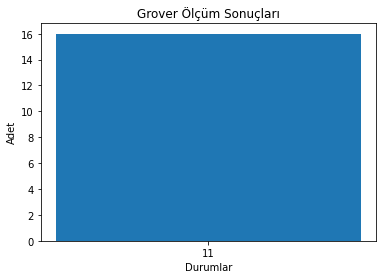

In [10]:
hist = dict()
for val in result.measurements["R"]:
    new_str = ""
    for s in val:
        new_str += str(s)
    try:
        hist[new_str] += 1
    except KeyError:
        hist[new_str] = 1
        
pyplot.bar(hist.keys(), hist.values())
pyplot.title("Grover Ölçüm Sonuçları")
pyplot.xlabel("Durumlar")
pyplot.ylabel("Adet")

frequencies = result.histogram(key="R", fold_func=bitstring)
print('Sonuçlar:\n{}'.format(frequencies))

# Doğru mu kontrol et.
most_common_bitstring = frequencies.most_common(1)[0][0]
print("\nEn çok bulunan sonuç: {}".format(most_common_bitstring))
print("Doğru mu? {}".format(most_common_bitstring == bitstring(xprime)))